<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1--Importation-des-modules-et-des-données" data-toc-modified-id="1--Importation-des-modules-et-des-données-1">1- Importation des modules et des données</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2">Preprocessing</a></span></li><li><span><a href="#2--Sélection-de-la-famille-et-TF-IDF" data-toc-modified-id="2--Sélection-de-la-famille-et-TF-IDF-3">2- Sélection de la famille et TF-IDF</a></span></li><li><span><a href="#3--Metric-learning" data-toc-modified-id="3--Metric-learning-4">3- Metric learning</a></span></li></ul></div>

# Problématique 2 : Similarité / Metric Learning

## 1- Importation des modules et des données

In [95]:
# Librairies 
import pandas as pd
import numpy as np
from scipy import stats as scs
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

import re
import random
import time

from Preprocessing_treetagger_v3 import *
from gensim import models, corpora

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
import metric_learn

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

chemin = "C:/Users/JN/Desktop/Telecom ParisTech/Cours/fil_rouge/github/Data/"

In [127]:
# # importation des données
# df1 = pd.read_csv(chemin+'similarity.csv',sep=';')
# prod_infos = df1[['brand','Key']]
# prod_infos['brand'] = prod_infos['brand'].fillna('')

# df2 = pd.read_csv(chemin+'20190403_df_train_all.csv')
# descriptions = df2[['productseller_name_clean','Product_family_innoscape']]

# df = pd.concat([descriptions, prod_infos], axis=1)
# df['description'] = df['productseller_name_clean'] + ' ' + df['brand']
# df = df[['description','Key','Product_family_innoscape']]
# df.head()

In [117]:
# df2.index

RangeIndex(start=0, stop=6650, step=1)

In [128]:
df_new = pd.read_csv(chemin+'df_metric_learning_test.csv')
df_new.rename(columns = {'label':'prod_fam'},inplace=True)
df2 = df_new[['product_name_x','prod_fam','id_page']]
df2.head()

product_name_x  prod_fam  \
0  SikaCeram Xtra, Colle à carrelage intérieur et...        27   
1  SikaCeram Xtra, Colle à carrelage intérieur et...        27   
2  Colle à carrelage tous carreaux intérieur et e...        27   
3  Sika Multiseal, Bande d'étanchéité autocollant...        27   
4  Sika Multiseal, Bande d'étanchéité autocollant...        27   

                    id_page  
0  /type/7612895071961.html  
1  /type/7612895071961.html  
2  /type/7612895071961.html  
3  /type/7612894021974.html  
4  /type/7612894021974.html

## Preprocessing

In [120]:
# Caractères spéciaux
dico1 = {",":" ", "'":" ", ";":" ", ":":" ", "\?":" ", "!":" ", "\.":'', "  ":" ", "  ":" ",
         "\(":"","\)":"","\[":"","\]":"","-":" ","\+":"","/":"","\*":"","–":" ",
         "&":"et"}

# Caractères avec accents
dico2 = {'à':'a','â':'a','ä':'a',
              'é':'e','è':'e','ê':'e','ë':'e',
              'ï':'i','î':'i',
              'ô':'o','ö':'o',
              'ù':'u','û':'u',
              'ç':'c'}

# Stop words & marques
stop_words = {'a',
             'ai',
             'aie',
             'aient',
             'aies',
             'ait',
             'as',
             'au',
             'aura',
             'aurai',
             'auraient',
             'aurais',
             'aurait',
             'auras',
             'aurez',
             'auriez',
             'aurions',
             'aurons',
             'auront',
             'aux',
             'avaient',
             'avais',
             'avait',
             'avec',
             'avez',
             'aviez',
             'avions',
             'avons',
             'ayant',
             'ayante',
             'ayantes',
             'ayants',
             'ayez',
             'ayons',
             'c',
             'ce',
             'ces',
             'd',
             'dans',
             'de',
             'des',
             'du',
             'elle',
             'en',
             'es',
             'est',
             'et',
             'eu',
             'eue',
             'eues',
             'eurent',
             'eus',
             'eusse',
             'eussent',
             'eusses',
             'eussiez',
             'eussions',
             'eut',
             'eux',
             'eûmes',
             'eût',
             'eûtes',
             'furent',
             'fus',
             'fusse',
             'fussent',
             'fusses',
             'fussiez',
             'fussions',
             'fut',
             'fûmes',
             'fût',
             'fûtes',
             'il',
             'j',
             'je',
             'l',
             'la',
             'le',
             'leur',
             'lui',
             'm',
             'ma',
             'mais',
             'me',
             'mes',
             'moi',
             'mon',
             'même',
             'n',
             'ne',
             'nos',
             'notre',
             'nous',
             'on',
             'ont',
             'ou',
             'par',
             'pas',
             'pour',
             'qu',
             'que',
             'qui',
             's',
             'sa',
             'se',
             'sera',
             'serai',
             'seraient',
             'serais',
             'serait',
             'seras',
             'serez',
             'seriez',
             'serions',
             'serons',
             'seront',
             'ses',
             'soient',
             'sois',
             'soit',
             'sommes',
             'son',
             'sont',
             'soyez',
             'soyons',
             'suis',
             'sur',
             't',
             'ta',
             'te',
             'tes',
             'toi',
             'ton',
             'tu',
             'un',
             'une',
             'vos',
             'votre',
             'vous',
             'y',
             'à',
             'étaient',
             'étais',
             'était',
             'étant',
             'étante',
             'étantes',
             'étants',
             'étiez',
             'étions',
             'été',
             'étée',
             'étées',
             'étés',
             'êtes',
             ',',
             '(',
             ')',
             '[',
             ']',
             '-',
             '/',
             '+',
             '*',
             '{',
             '}',
             '!',
             ';',
             ':',
             '?',
             '.',
             '&'
             }


#marques =  set(open('../Data/marques.txt').read().split())

#stop_words = stop_words.union(marques)

In [126]:
df_clean = preprocessing(df2, ['product_name_x'], dico1, dico2, stop_words, "C:/TreeTagger")
df_clean = df_clean[['product_name_x_clean','prod_fam','id_page']]
df_clean.rename(columns={'product_name_x_clean':'description','id_page':'Key','prod_fam':'Product_family_innoscape'},inplace=True)
df = df_clean

In [129]:
df.head()

description  \
0  blanc carrelage carreau coller exterieur xtra ...   
1  blanc carrelage carreau coller exterieur xtra ...   
2  blanc carrelage carreau tout exterieur colle x...   
3  bander autocollant etancheite multiseal dechir...   
4  bander autocollant etancheite multiseal dechir...   

   Product_family_innoscape                       Key  
0                        27  /type/7612895071961.html  
1                        27  /type/7612895071961.html  
2                        27  /type/7612895071961.html  
3                        27  /type/7612894021974.html  
4                        27  /type/7612894021974.html

On affiche les familles avec les effectifs les plus importants :

In [130]:
df['Product_family_innoscape'].value_counts()

27     394
62     267
60     214
55     174
98     174
64     131
51     121
56     102
50      79
84      79
94      78
61      73
52      69
95      67
63      66
100     64
93      60
99      55
58      53
47      50
89      44
88      40
97      32
59      28
34      28
13      26
57      25
96      21
53      19
54      18
11      17
108     17
41      16
32      16
15      15
80      14
28      12
68      12
49      11
75      11
21       9
18       9
5        8
79       8
91       8
78       7
81       6
74       5
82       5
20       5
26       5
7        4
85       4
12       3
107      3
39       3
29       2
22       1
10       1
Name: Product_family_innoscape, dtype: int64

## 2- Sélection de la famille et TF-IDF

In [131]:
target_fam = 27
data = df[df['Product_family_innoscape']==target_fam]
data.shape[0]

394

In [132]:
vectorizer = TfidfVectorizer(lowercase=False)
df = df.dropna()
tf_idf_total = sparse.csr_matrix(vectorizer.fit_transform(data["description"]))
tfidf_feature_names = vectorizer.get_feature_names()

In [133]:
print('Taille vocabulaire tf-idf : ', len(tfidf_feature_names))

Taille vocabulaire tf-idf :  236


In [134]:
X = pd.DataFrame(tf_idf_total.todense()).set_index(data.index.values)
Y = data['Key']

In [135]:
# On retire les produits qui n'ont pas au moins une paire (valeur variable) Xtrain / Xtest
counts = Y.value_counts()
cond = [label for label in counts.index if counts[label] < 5]
label_to_remove = [i for i in X.index if Y[i] in cond]

print('produits retirés faute de produits identiques : %r' %len(label_to_remove))

X2 = X.drop(label_to_remove, axis=0)
Y2 = Y.drop(label_to_remove, axis=0)

produits retirés faute de produits identiques : 82


In [136]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X2,Y2,test_size=0.2, random_state = 548, stratify=Y2)

## 3- Metric learning

In [157]:
n_neighbors = 4

# Model LMNN
lmnn = metric_learn.LMNN(k = n_neighbors, learn_rate=1e-6)

# Fit the data
lmnn.fit(Xtrain, Ytrain)

C:\Users\JN\Anaconda3\lib\site-packages\metric_learn\lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


python_LMNN(convergence_tol=0.001, k=4, learn_rate=1e-06, max_iter=1000,
      min_iter=50, regularization=0.5, use_pca=True, verbose=False)

In [158]:
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(lmnn.transform(Xtrain), Ytrain)
Ypred = knn.predict(lmnn.transform(Xtest))
lmnn_acc = knn.score(lmnn.transform(Xtest), Ytest)
print('LMNN accuracy on test set of {} points: {:.4f}'.format(Xtest.shape[0], lmnn_acc))

LMNN accuracy on test set of 63 points: 0.7937


Visuellement:

In [143]:
# Fonction pour visualization TSNE
def tsne(X, y, n_components):
    time_start = time.time()
    X_tsne = TSNE(n_components=n_components, init='pca').fit_transform(X)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    color_codes = dict(zip(y.unique(),range(y.unique().shape[0])))
    colors = [color_codes[label] for label in y]
    plt.figure(figsize=(8, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors)
    plt.show()

Avant transformation :

t-SNE done! Time elapsed: 0.47974181175231934 seconds


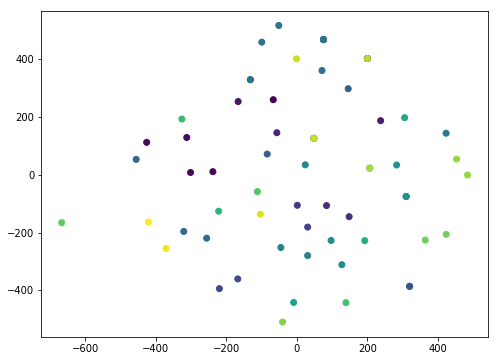

In [152]:
tsne(Xtest, Ytest, 2)

Après transformation :

t-SNE done! Time elapsed: 0.48009300231933594 seconds


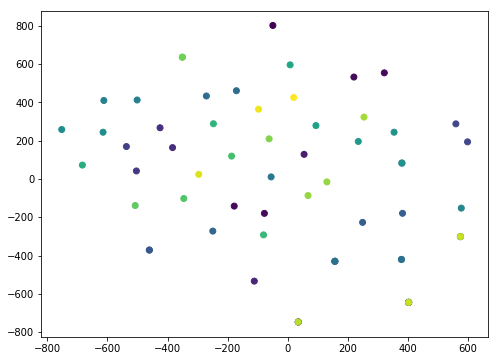

In [151]:
tsne(lmnn.transform(Xtest), Ytest, 2)